In [17]:
from zpmeta.funcs.func import Func 
from pandas import DataFrame
import pandas as pd
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import math
import scipy
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from zpanalytics.returns.basic import Cumulate_g_Returns
from zpanalytics.returns.drawdowns import Drawdowns_g_R, MaxDrawdowns_g_R, LongestDrawdownPeriods_g_R
from zpanalytics.returns.performance import Performance_g_Returns
from zpanalytics.plotting.basic import plot_linechart, plot_barchart, plot_heatmap
from datetime import datetime

In [5]:
def calc_sharpe_ratio(ts):
    '''
    @summary - Mean of excess returns over the risk free rate divided by the standard deviation of the portfolio return series. 
    '''
    excessReturns = ts
    geometric_mean = scipy.stats.mstats.gmean(1.0 + excessReturns)
    gmean = geometric_mean ** (12.0) - 1.0
    stdev = (excessReturns.std(skipna=True)) * math.sqrt(12.0)
    
    return gmean / stdev

def convert_my_table_to_series(returns_my_table, name='PORTFOLIO'):
    returns_my_table = returns_my_table/100.0
    returns_series = returns_my_table.stack().reset_index()
    returns_series.columns = ['Year', 'Month', name]
    returns_series['Year'] = returns_series['Year'].map(lambda x: x.year)
    # given the Year ad Month coumns in returns_prev, calculate a date column that has the last day of the month
    returns_series['Date'] = returns_series.apply(lambda x: pd.to_datetime(str(x['Year']) + '-' + str(x['Month']) + '-01') + relativedelta(months=1) - relativedelta(days=1), axis=1)
    returns_series = returns_series.set_index('Date')
    returns_series = returns_series.drop(['Year', 'Month'], axis=1)
    
    return returns_series



In [10]:
worksp = r'C:\Users\raman\OneDrive\MSx\CMC\Resume\PM\PM_PitchDeck\Calculations3'
from datetime import datetime
# create the workspace if not there and set the working directory to the location of the data file
if not os.path.exists(worksp):
    os.makedirs(worksp)
os.chdir(worksp)

start_date, end_date = datetime(2002, 1, 1), datetime(2023, 3, 31)


In [103]:

filename = 'Raw_Returns 2.xlsx'

# read portfolio returns
returns_prev_est = convert_my_table_to_series(pd.read_excel(os.path.join(worksp, filename), sheet_name='prev_est', index_col=0, 
                                                            parse_dates=True), name='PORTFOLIO_SameCloseTC').truncate(before=start_date, after=end_date)
returns_close_non = convert_my_table_to_series(pd.read_excel(os.path.join(worksp, filename), sheet_name='close_non', index_col=0, 
                                                             parse_dates=True), name='PORTFOLIO').truncate(before=start_date, after=end_date)
returns_close_est = convert_my_table_to_series(pd.read_excel(os.path.join(worksp, filename), sheet_name='close_est', index_col=0, 
                                                             parse_dates=True), name='PORTFOLIO_NextCloseTC').truncate(before=start_date, after=end_date)

# read environment returns
returns_env = pd.read_excel(os.path.join(worksp, 'Raw_Returns.xlsx'), sheet_name='Environments', index_col=0, parse_dates=True).truncate(before=start_date, after=end_date)

# read benchmark returns
returns_benchmark = pd.read_excel(os.path.join(worksp, 'Raw_Returns.xlsx'), sheet_name='Benchmarks', index_col=0, parse_dates=True).truncate(before=start_date, after=end_date)

# join all returns into a single df
returns = returns_prev_est.join(returns_close_non).join(returns_close_est).join(returns_env).join(returns_benchmark).truncate(before=start_date, after=end_date)

# calculate the excess and total returns that are vol adj
returns_excess = returns.sub(returns['RFR'], axis=0)
returns_excess[['PORTFOLIO_SameCloseTC','PORTFOLIO','PORTFOLIO_NextCloseTC']] = returns_excess[['PORTFOLIO_SameCloseTC','PORTFOLIO','PORTFOLIO_NextCloseTC']].div(returns_excess[['PORTFOLIO_SameCloseTC','PORTFOLIO','PORTFOLIO_NextCloseTC']].std(axis=0), axis=1)*(0.06/np.sqrt(12))
returns_excess_A = Cumulate_g_Returns({'freq': 'A', 'extrapolate': True})(returns_excess)

returns[['PORTFOLIO_SameCloseTC','PORTFOLIO','PORTFOLIO_NextCloseTC']] = returns_excess[['PORTFOLIO_SameCloseTC','PORTFOLIO', 'PORTFOLIO_NextCloseTC']].add(returns['RFR'], axis=0)
returns_A = Cumulate_g_Returns({'freq': 'A', 'extrapolate': True})(returns)

# vol adjust all the returns
returns_excess_voladj = returns_excess.div(returns_excess.std(axis=0), axis=1)*(0.06/np.sqrt(12))
returns_total_voladj = returns_excess_voladj.add(returns['RFR'], axis=0)


with pd.ExcelWriter('Processed_Returns_3.xlsx') as writer:
    returns.to_excel(writer, sheet_name='Monthly_Total')
    returns_excess.to_excel(writer, sheet_name='Monthly Excess')
    
    returns_excess_voladj.to_excel(writer, sheet_name='Monthly Excess Vol Adj')
    returns_total_voladj.to_excel(writer, sheet_name='Monthly Total Vol Adj')
    
    returns_A.to_excel(writer, sheet_name='Annual_Total')
    returns_excess_A.to_excel(writer, sheet_name='Annual Excess')
    


In [16]:
gett_returns = (pd.read_excel(os.path.join(worksp, 'GETT_Portfolio_Returns_CSV.xlsx'), sheet_name='Daily', index_col=0, parse_dates=True, 
                              header=[0,1,2]))
gett_returns.index = pd.to_datetime(gett_returns.index.date)
gett_returns = gett_returns.truncate(before=start_date, after=end_date)

# select the columns of the GETT portfolio where RfType is 'Total Return'
gett_returns = gett_returns.xs('Total', axis=1, level='RfType',drop_level=True)
print(gett_returns)

PORTFOLIO       GETT                                                    \
TC         close_est close_non  open_est  open_non  prev_est  prev_non   
2002-01-02       NaN       NaN  0.007744  0.007744  0.012827  0.012827   
2002-01-03 -0.009028 -0.008948 -0.012286 -0.012208 -0.011629 -0.011551   
2002-01-04  0.013614  0.013690  0.014547  0.014623  0.015612  0.015688   
2002-01-07  0.009758  0.009814  0.009225  0.009282  0.009202  0.009258   
2002-01-08 -0.009136 -0.009050 -0.007749 -0.007664 -0.007941 -0.007855   
...              ...       ...       ...       ...       ...       ...   
2023-03-27  0.006027  0.006133  0.006598  0.006704  0.007358  0.007464   
2023-03-28  0.002295  0.002379  0.002779  0.002863  0.002732  0.002816   
2023-03-29  0.002460  0.002549  0.002578  0.002666  0.002441  0.002529   
2023-03-30  0.002354  0.002428  0.002672  0.002746  0.002722  0.002796   
2023-03-31 -0.003997 -0.003890 -0.004284 -0.004178 -0.004480 -0.004374   

PORTFOLIO                      GETT_M

In [111]:

# calculate the annualized Sharpe Ratio
sharpe_ratio = calc_sharpe_ratio(returns_excess)
sharpe_ratio.name = 'Sharpe Ratio'

# calculate the annualized Sharpe Ratio for last 5 years
sharpe_ratio_5y = calc_sharpe_ratio(returns_excess.tail(60))
sharpe_ratio_5y.name = 'Sharpe Ratio (5y)'

# calculate the total 1 year, 3 year, 5 year, and 10 year returns (one return for each period)
returns_1y = (1.0 + returns_excess.tail(12)).prod(skipna=True) - 1.0
returns_5y = (1.0 + returns_excess.tail(60)).prod(skipna=True).map(lambda x: x**(12/60) - 1.0).to_frame('Geometric Mean (5Y)')
returns_all = (1.0 + returns_excess).prod(skipna=True).map(lambda x: x**(12/len(returns_excess)) - 1.0).to_frame('Geometric Mean')


# calculate the annualized standard deviation of returns
std_dev = returns_excess.std() * np.sqrt(12)
std_dev.name = 'Ann. Vol'

# calculate the average and median excess returns
avg_excess_return = returns_excess.mean()*12
avg_excess_return.name = 'Avg Excess Return'

avg_excess_return_5y = returns_excess.tail(60).mean()*12
avg_excess_return_5y.name = 'Avg Excess Return (5y)'


# combine the returns, standard deviation, and Sharpe Ratio into a single df
results = pd.concat([returns_all, returns_5y, avg_excess_return, avg_excess_return_5y, std_dev, sharpe_ratio, sharpe_ratio_5y], axis=1)
print(results)

                       Geometric Mean  Geometric Mean (5Y)  Avg Excess Return  \
PORTFOLIO_SameCloseTC        0.187031             0.177669           0.174448   
PORTFOLIO                    0.167227             0.147528           0.157397   
PORTFOLIO_NextCloseTC        0.141027             0.110538           0.134425   
MSCI ACWI                    0.056440             0.053642           0.067722   
S&P GSCI                    -0.005509             0.033704           0.022780   
BTSYTRUH                     0.020560            -0.006719           0.020888   
RFR                          0.000000             0.000000           0.000000   
SG Macro Quant               0.037024             0.007344           0.038213   
SG Macro Discret             0.046938             0.036108           0.046872   

                       Avg Excess Return (5y)  Ann. Vol  Sharpe Ratio  \
PORTFOLIO_SameCloseTC                0.166183  0.060000      3.117190   
PORTFOLIO                            0.1400

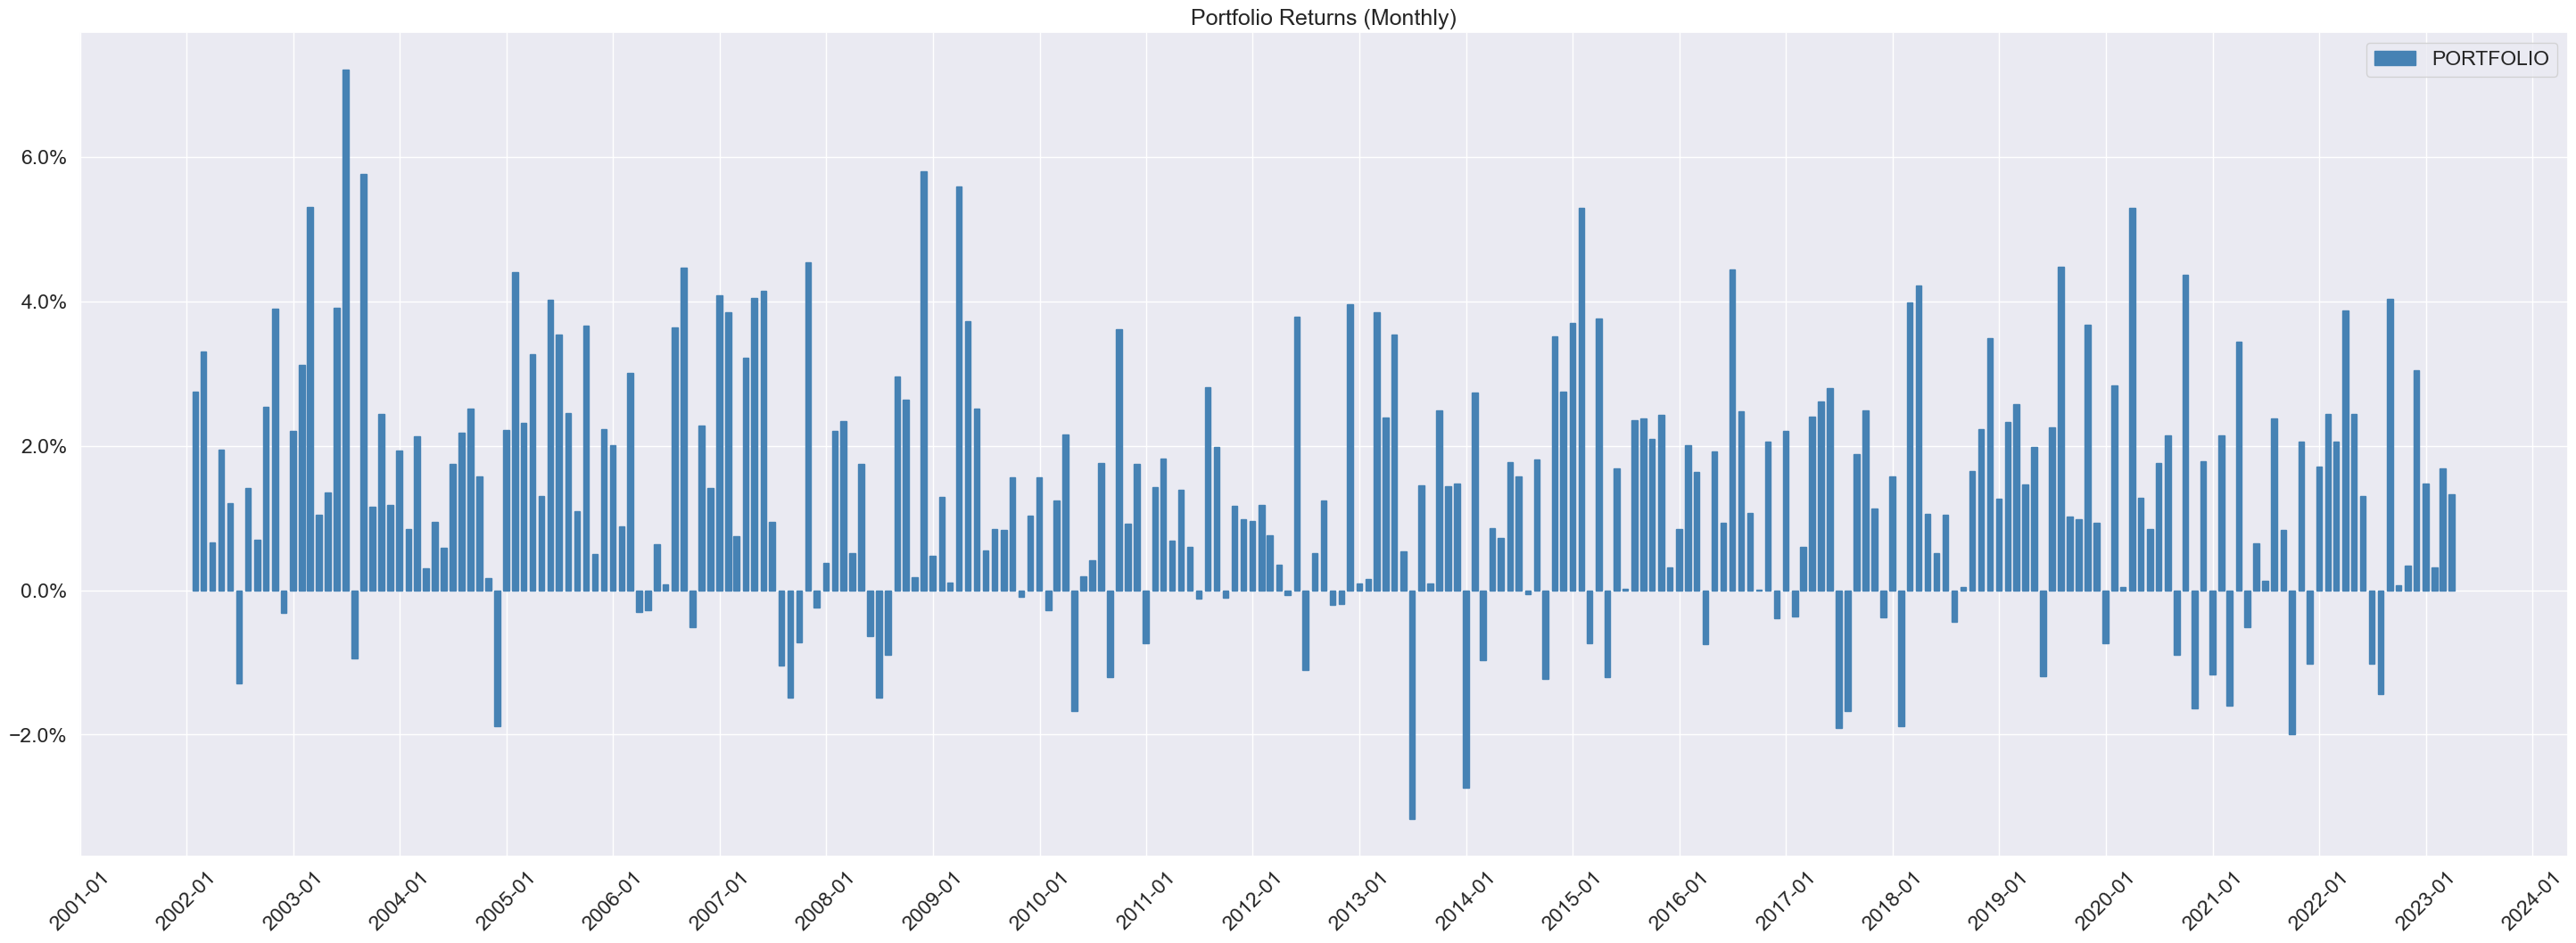

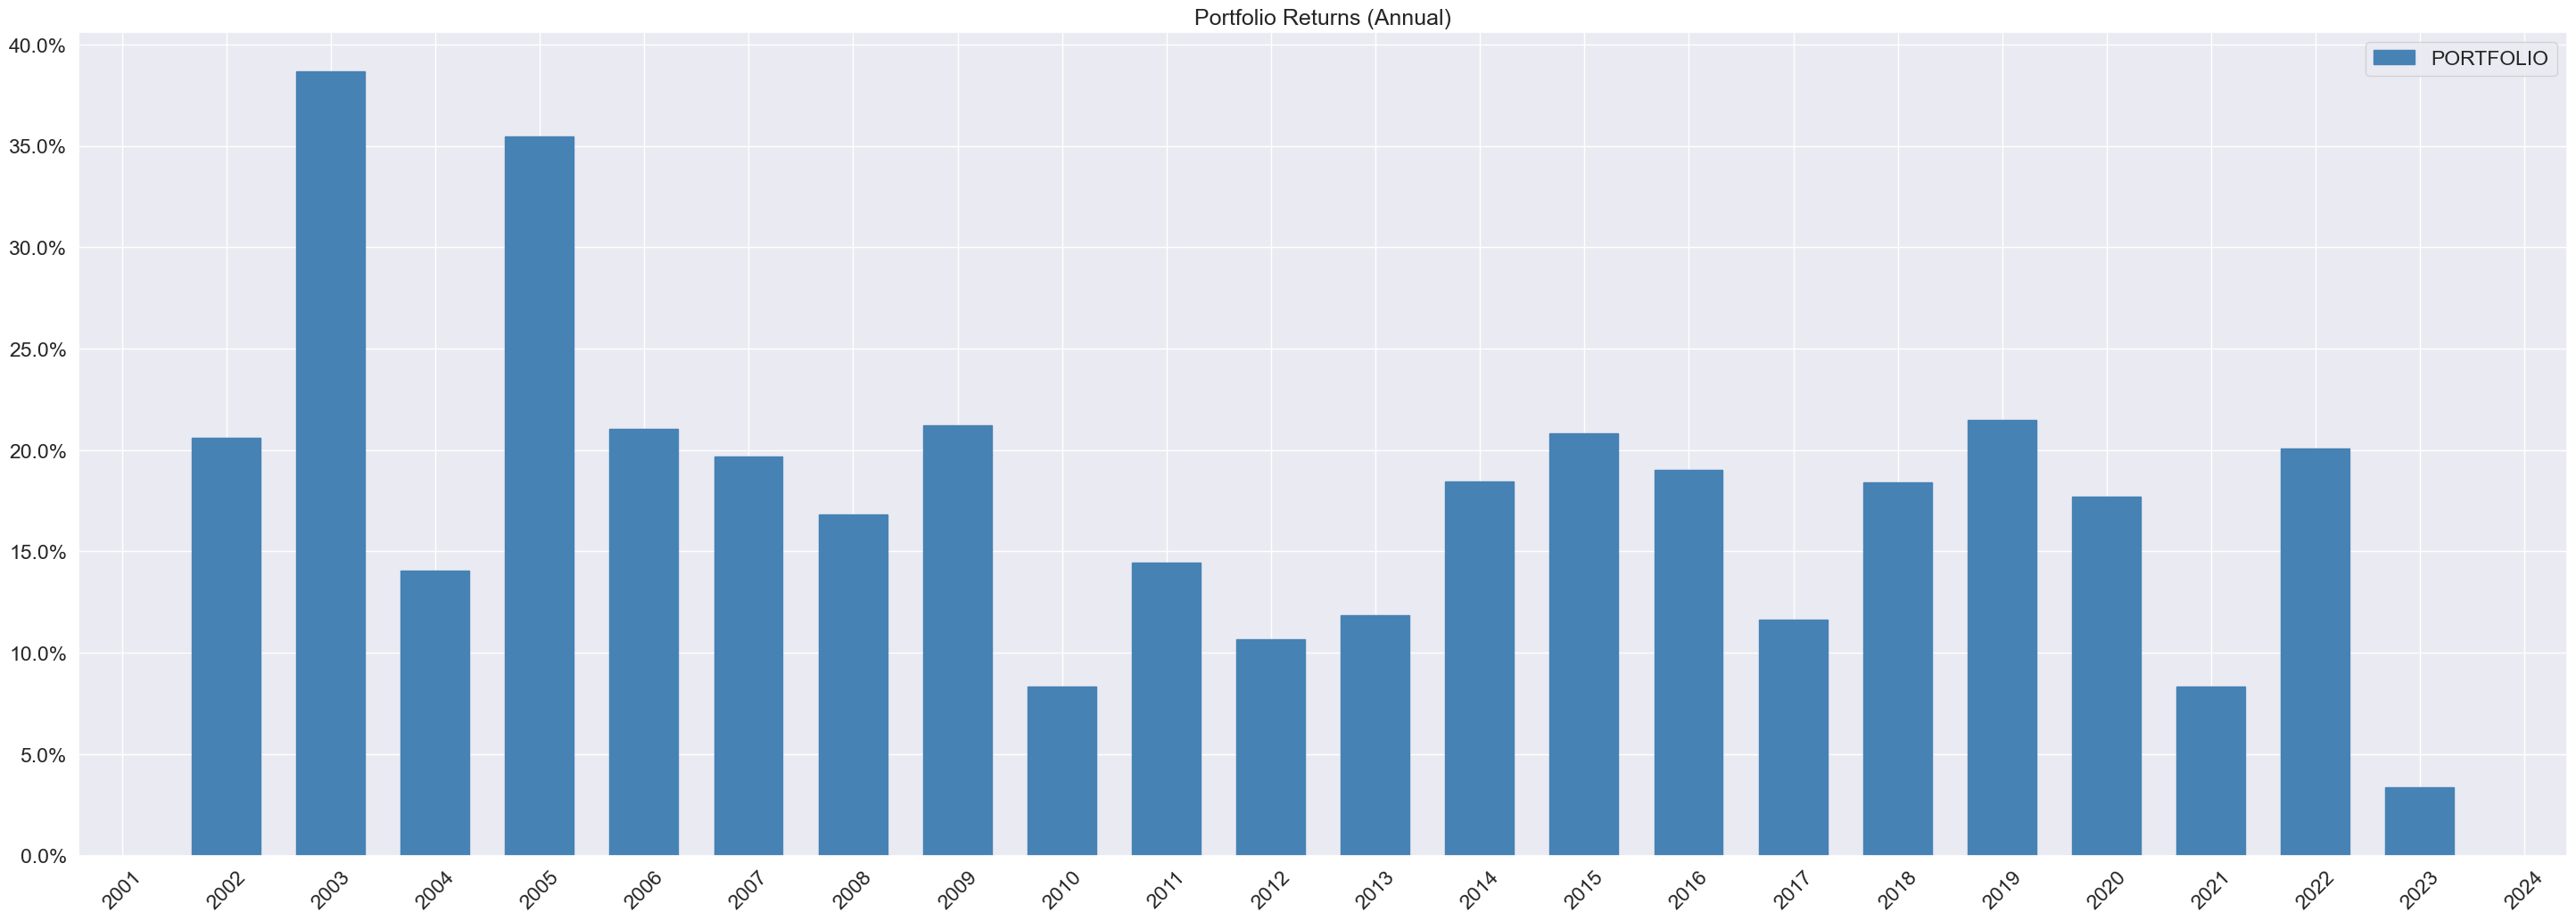

In [112]:
# plot the monthly and annual returns as bar charts
plot_barchart(returns['PORTFOLIO'], 'Portfolio Returns (Monthly)', 'Results Portfolio Returns Monthly.png', '%Y-%m', 20)

returns_A_plot = returns_A.copy()
returns_A_plot.index = returns_A_plot.index.map(lambda x: x - relativedelta(years=1))
plot_barchart(returns_A_plot['PORTFOLIO'], 'Portfolio Returns (Annual)', 'Results Portfolio Returns Annual.png', '%Y', 240)

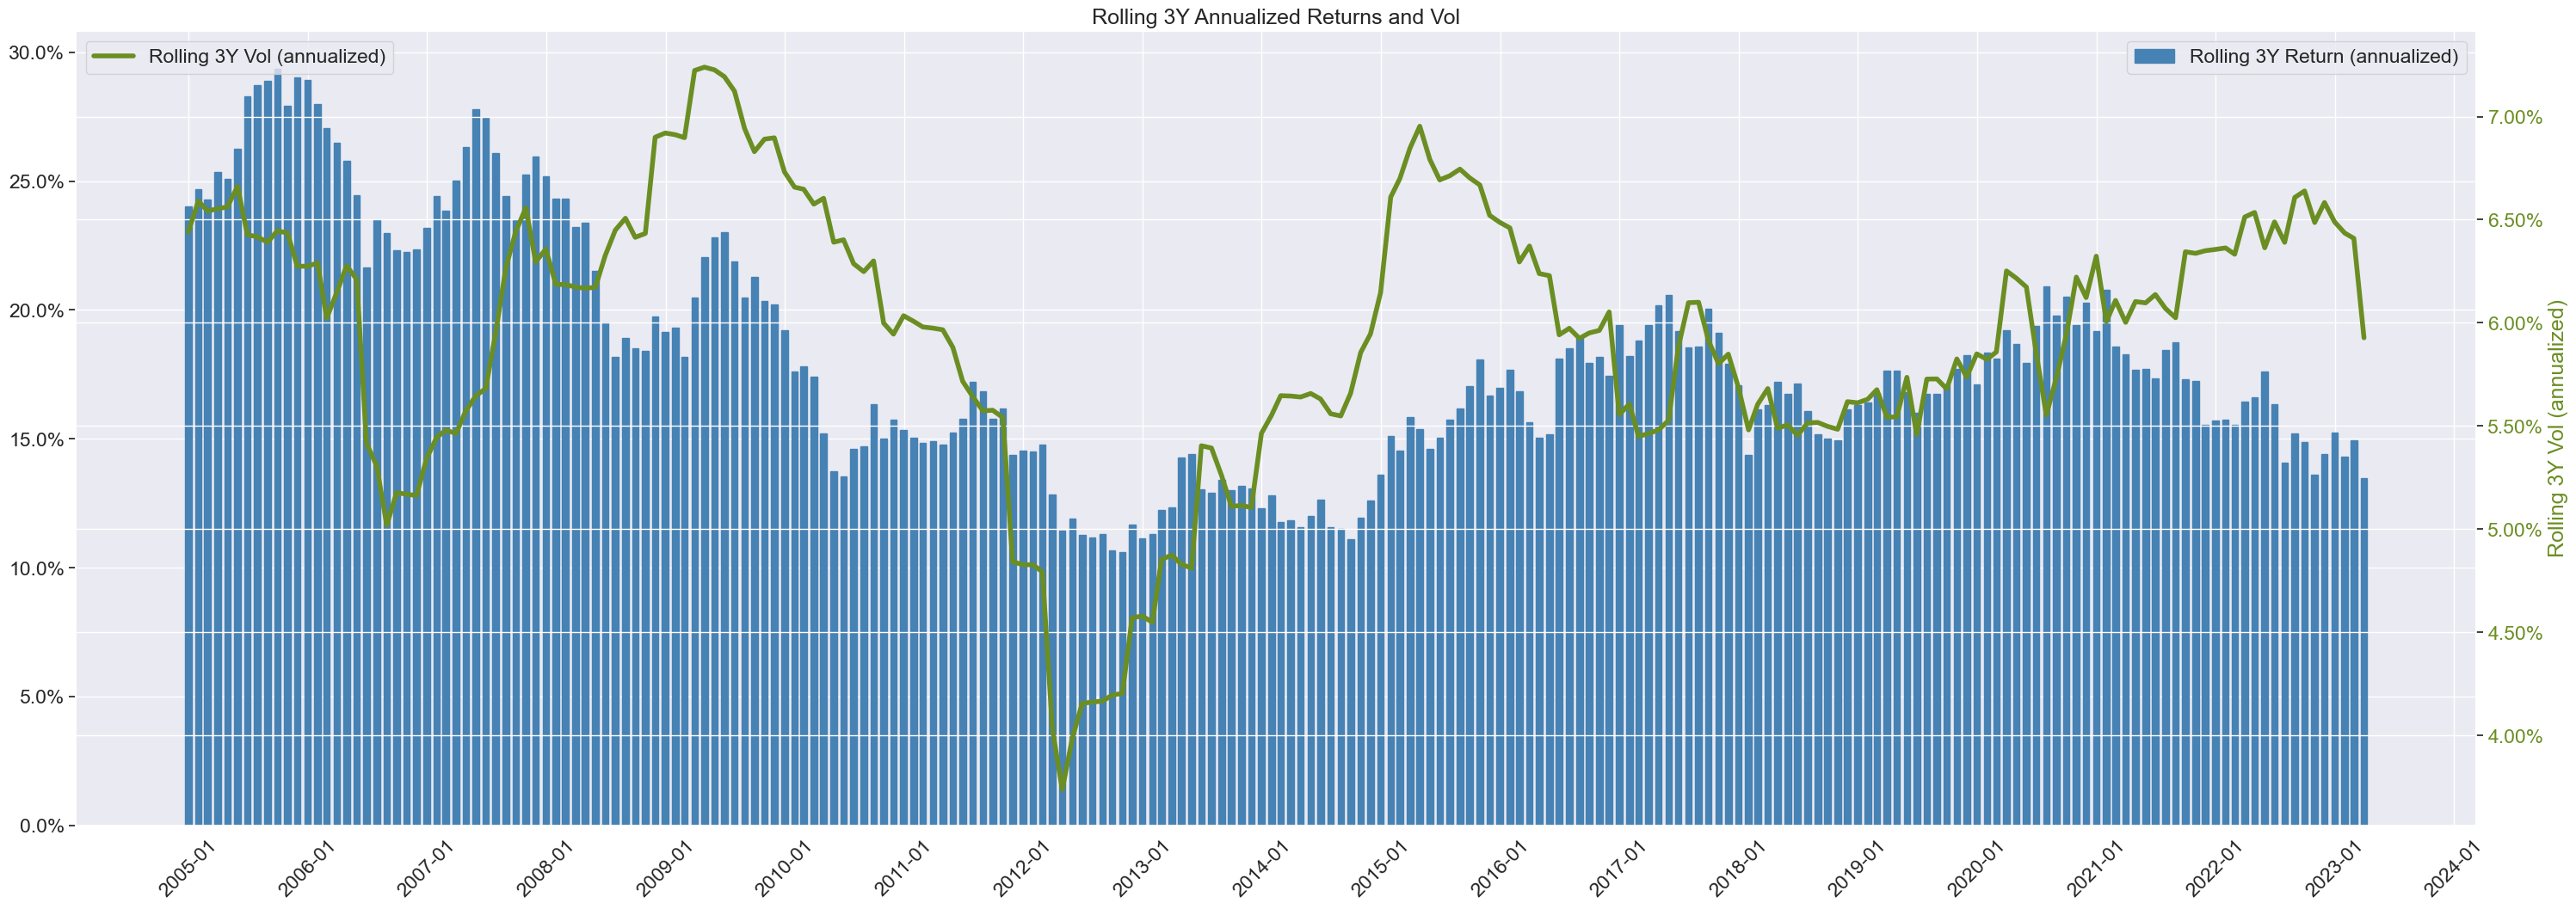

In [113]:
# calculate rolling 3 year returns of total returns and plot them
returns_3y = returns.rolling(36).apply(lambda x: (1.0 + x).prod()**(12/36) - 1.0)
vol_3y = returns.rolling(36).std() * np.sqrt(12)

returns_3y = returns_3y['PORTFOLIO']#.to_frame('Rolling 3Y Return (annualized)')
returns_3y.name = 'Rolling 3Y Return (annualized)'
vol_3y = vol_3y['PORTFOLIO']#.to_frame('Rolling 3Y Vol (annualized)')
vol_3y.name = 'Rolling 3Y Vol (annualized)'

# plot_linechart(std_dev_3y[['PORTFOLIO']], 'Rolling 3Y Standard Deviation (Annualized)', 'Results Rolling 3Y Vol.png')
plot_barchart(returns_3y, 'Rolling 3Y Annualized Returns and Vol', 'Results Rolling 3Y.png', '%Y-%m', 20, 
              vol_3y)


Max Drawdowns
 PORTFOLIO_SameCloseTC   -0.037223
PORTFOLIO               -0.035463
PORTFOLIO_NextCloseTC   -0.040677
MSCI ACWI               -0.545089
S&P GSCI                -0.872163
BTSYTRUH                -0.126421
RFR                     -0.000002
SG Macro Quant          -0.076044
SG Macro Discret        -0.058175
dtype: float64


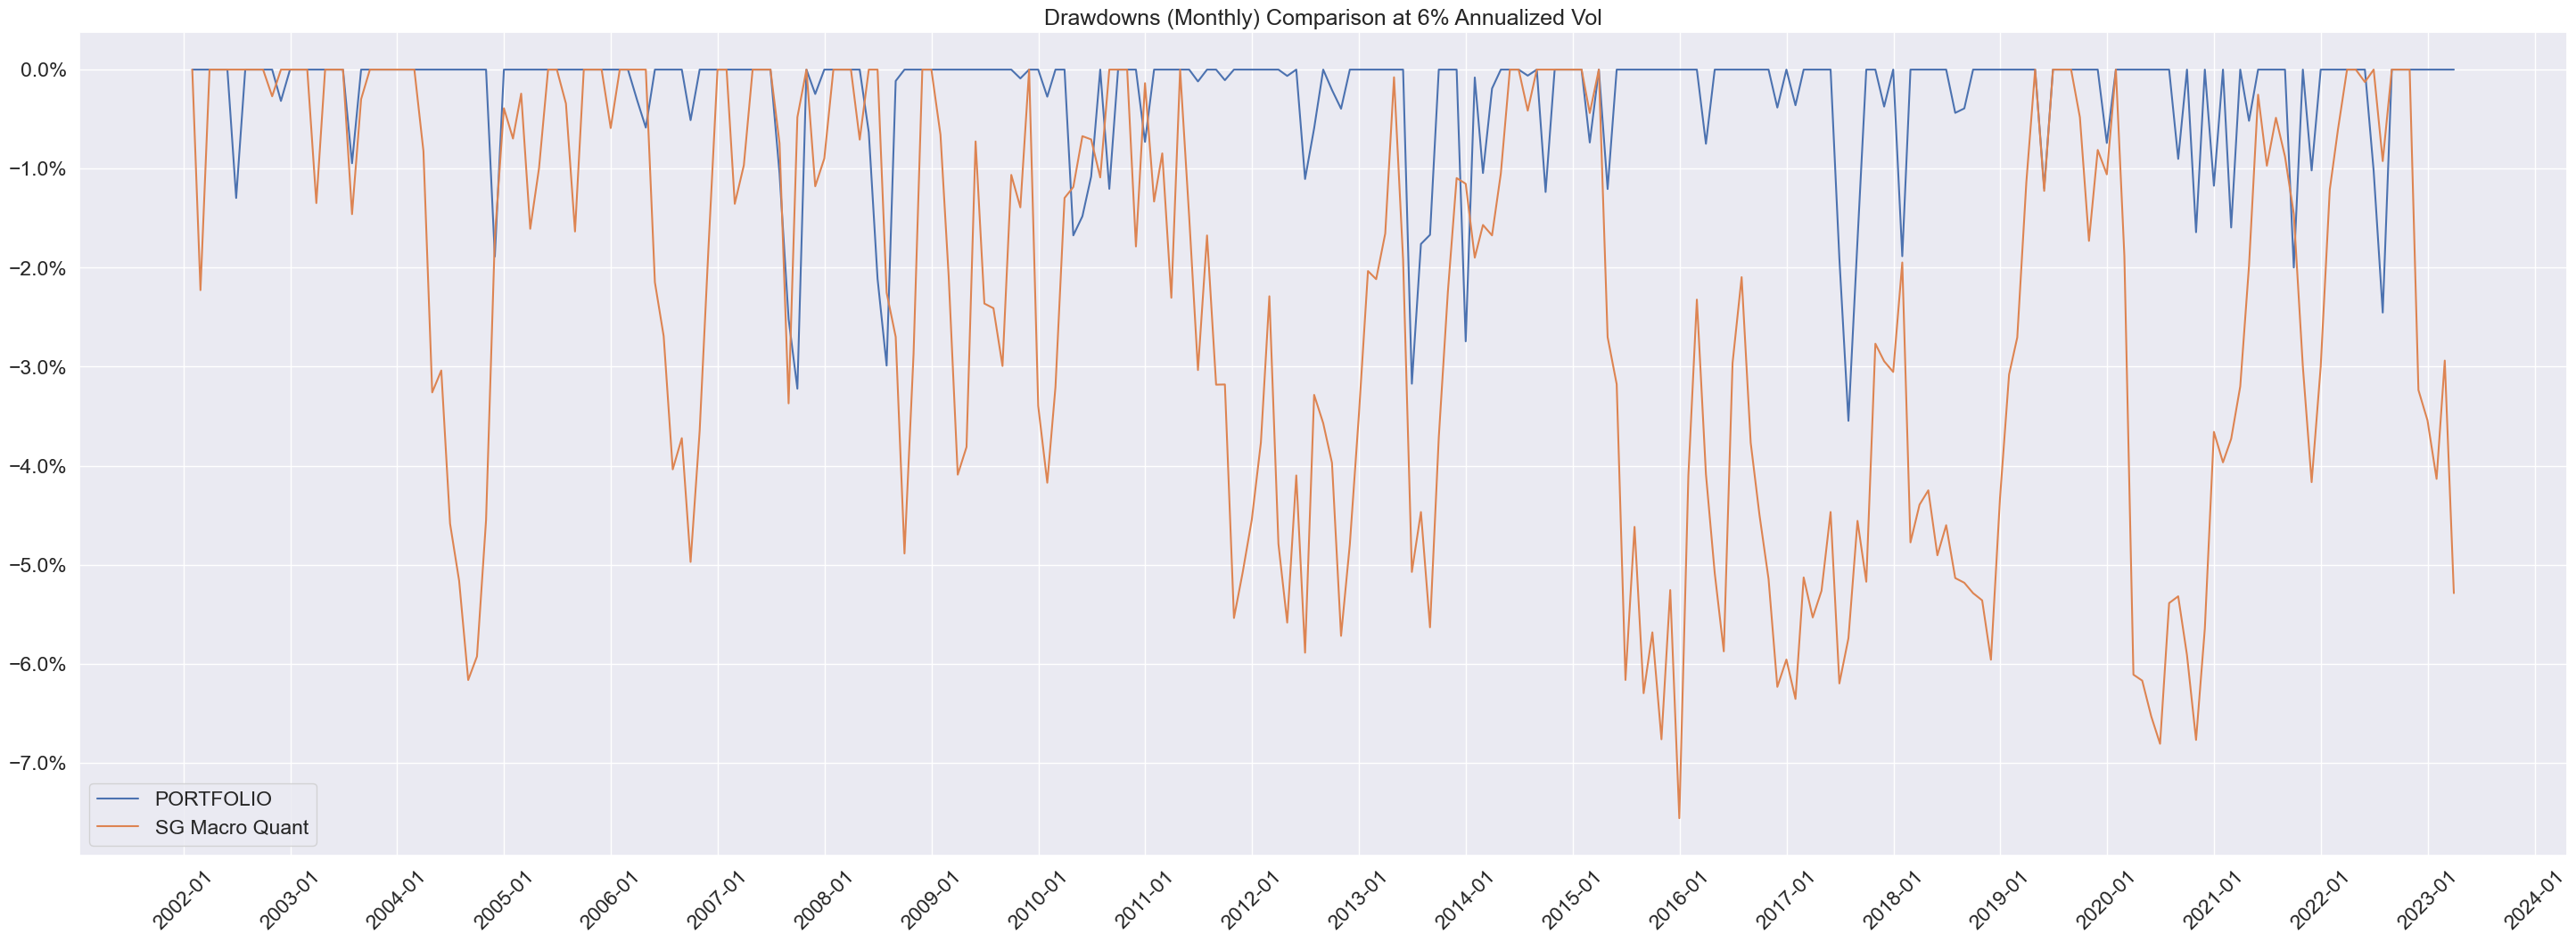

Longest Drawdown Periods    PORTFOLIO                                                  
  start_date   end_date  length max_drawdown max_drawdown_date
1 2008-05-31 2008-08-31 92 days    -0.029883        2008-07-31
2 2013-12-31 2014-03-31 90 days    -0.027437        2013-12-31
3 2017-06-30 2017-08-31 62 days    -0.035463        2017-07-31
4 2013-06-30 2013-08-31 62 days    -0.031714        2013-06-30
5 2007-07-31 2007-09-30 61 days    -0.032220        2007-09-30


In [119]:
drawdowns_total = Drawdowns_g_R({'freq': 'M'})(returns)
drawdowns_total_voladj = Drawdowns_g_R({'freq': 'M'})(returns_total_voladj)

# find the maximum drawdowns
max_drawdown = drawdowns_total.min()
print("Max Drawdowns\n", max_drawdown)

# drawdown plots
plot_linechart(drawdowns_total_voladj[['PORTFOLIO','SG Macro Quant']], 'Drawdowns (Monthly) Comparison at 6% Annualized Vol', 
               'Drawdowns_Monthly_Comparison.png')

# longest drawdown periods
longest_drawdown_periods_M = LongestDrawdownPeriods_g_R({'freq': 'M', 'num_periods': 5})(returns[['PORTFOLIO']])
print("Longest Drawdown Periods",longest_drawdown_periods_M)

# save the original returns, the daily drawdowns and the monthly drawdowns, and the longest drawdown periods in separate sheet of an XLS file 
# with pd.ExcelWriter('GETT_Portfolio_Returns_Analysis.xlsx') as writer:
#     returns.to_excel(writer, sheet_name='Returns')
#     
#     drawdowns_B.to_excel(writer, sheet_name='Drawdowns Daily')
#     drawdowns_M.to_excel(writer, sheet_name='Drawdowns Monthly')
# 
#     longest_drawdown_periods_B.to_excel(writer, sheet_name='Drawdown Durations Daily')
#     longest_drawdown_periods_M.to_excel(writer, sheet_name='Drawdown Durations Monthly')


In [116]:
# regress the excess returns (returns_excess) against the market (MXWD) excess returns
import statsmodels.api as sm

def regress_portfolio_against_market(reg_ret, portfolio_name='PORTFOLIO', market_name='MSCI ACWI'):
    # create a new df with the excess returns of the market and the portfolio
    regression_df = reg_ret[[portfolio_name, market_name]]
    
    # drop any rows with missing values
    regression_df = regression_df.dropna()
    
    # create a constant column for the regression
    regression_df = sm.add_constant(regression_df)
    
    # run the regression
    regression_results = sm.OLS(regression_df[portfolio_name], regression_df[['const', market_name]]).fit()
    
    # print the regression results
    print(regression_results.summary())
    
for name in ['PORTFOLIO', 'SG Macro Quant']:
    regress_portfolio_against_market(returns_excess, portfolio_name=name)
    regress_portfolio_against_market(returns_excess.tail(60), portfolio_name=name)



                            OLS Regression Results                            
Dep. Variable:              PORTFOLIO   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.09794
Date:                Tue, 02 Jul 2024   Prob (F-statistic):              0.755
Time:                        18:46:31   Log-Likelihood:                 672.97
No. Observations:                 255   AIC:                            -1342.
Df Residuals:                     253   BIC:                            -1335.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.001     11.941      0.0

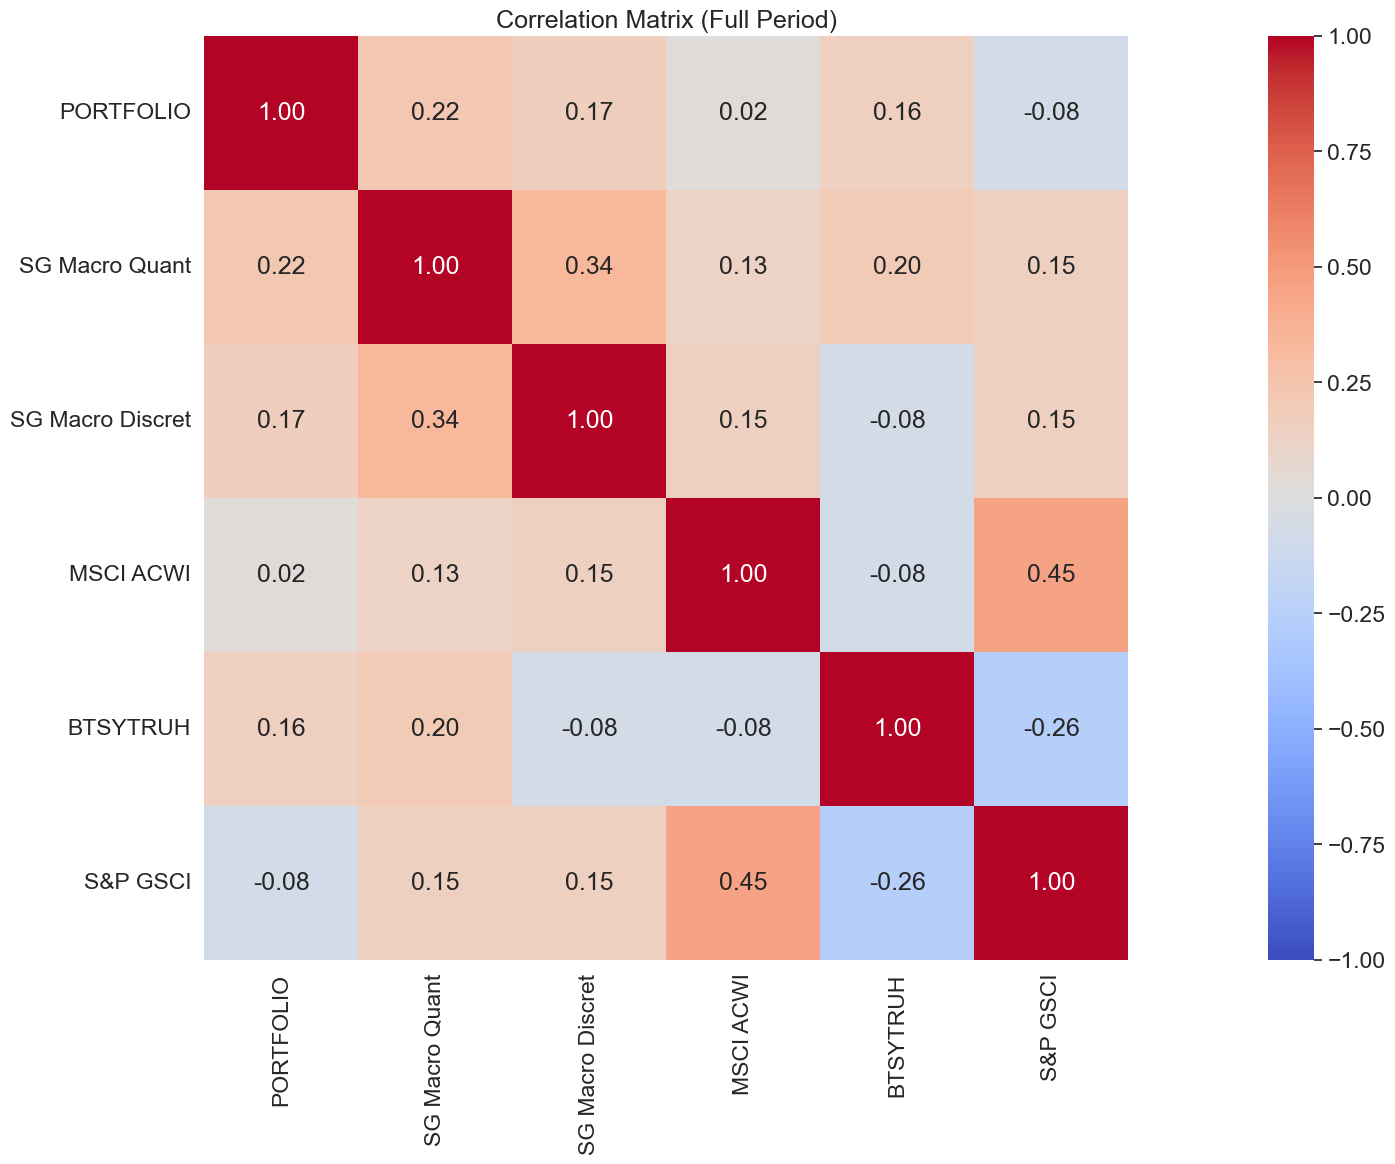

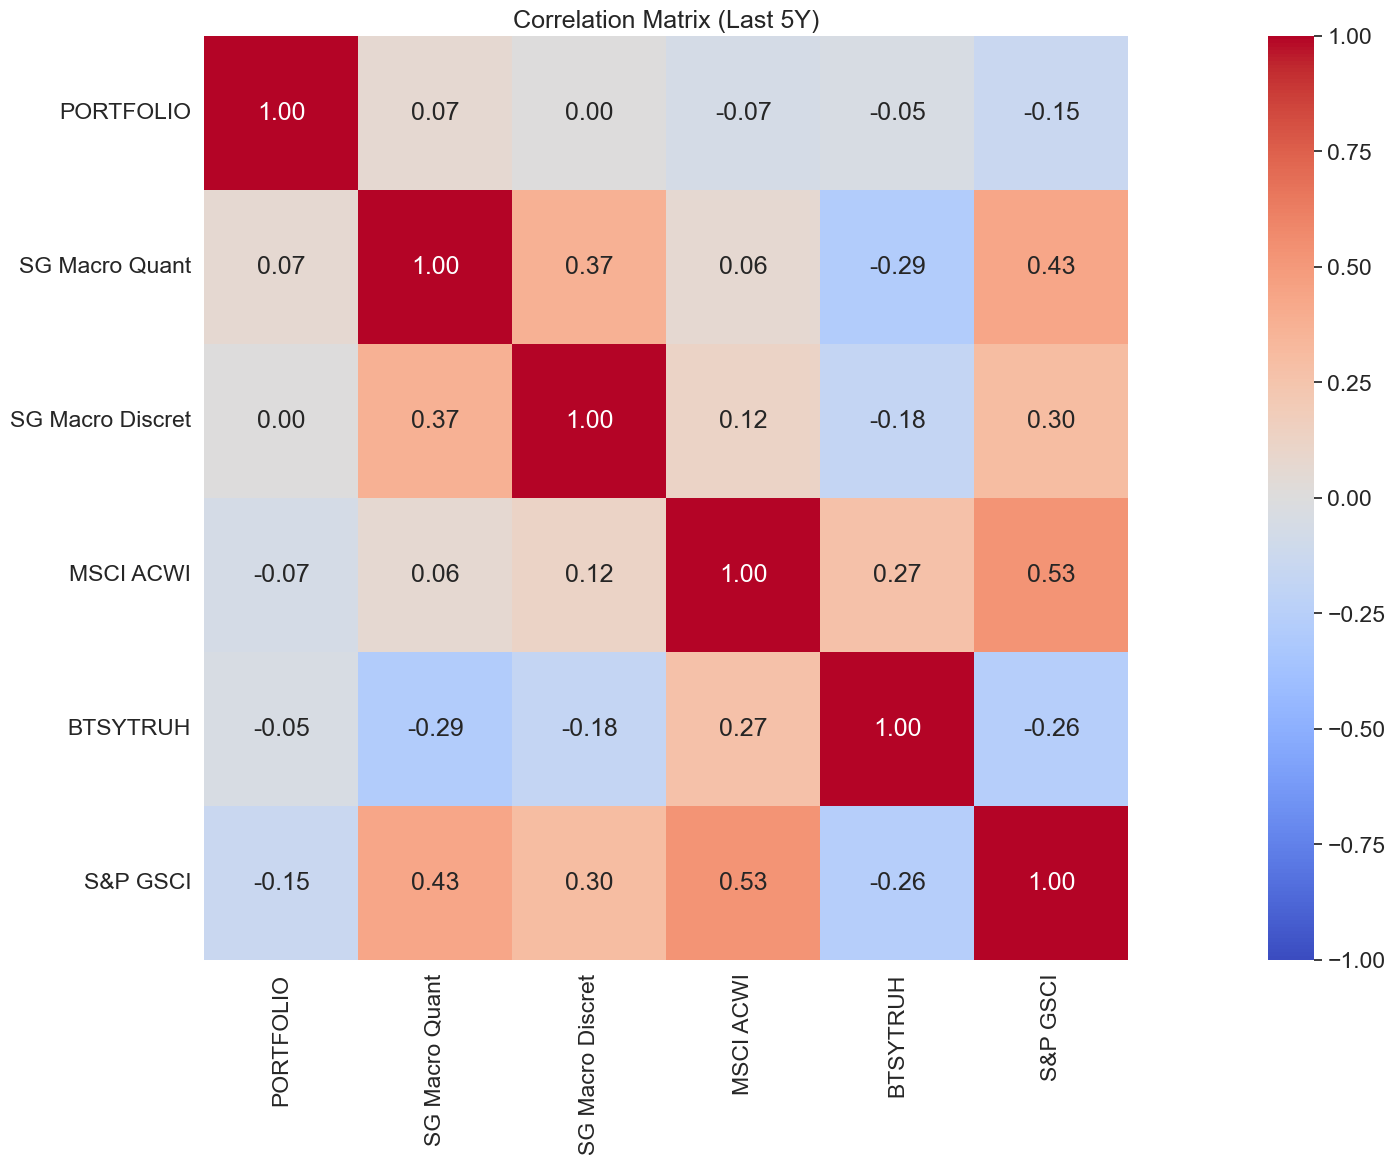

In [98]:
# calculate the correlation between all excess returns
correlation = returns_excess[['PORTFOLIO', 'SG Macro Quant', 'SG Macro Discret', 'MSCI ACWI', 'BTSYTRUH', 'S&P GSCI']].corr()
correlation_5Y = returns_excess.tail(60)[['PORTFOLIO', 'SG Macro Quant', 'SG Macro Discret', 'MSCI ACWI', 'BTSYTRUH', 'S&P GSCI']].corr()
    
plot_heatmap(correlation, 'Correlation Matrix (Full Period)', 'Results Correlation Matrix Full.png')
plot_heatmap(correlation_5Y, 'Correlation Matrix (Last 5Y)', 'Results Correlation Matrix 5Y.png')

    


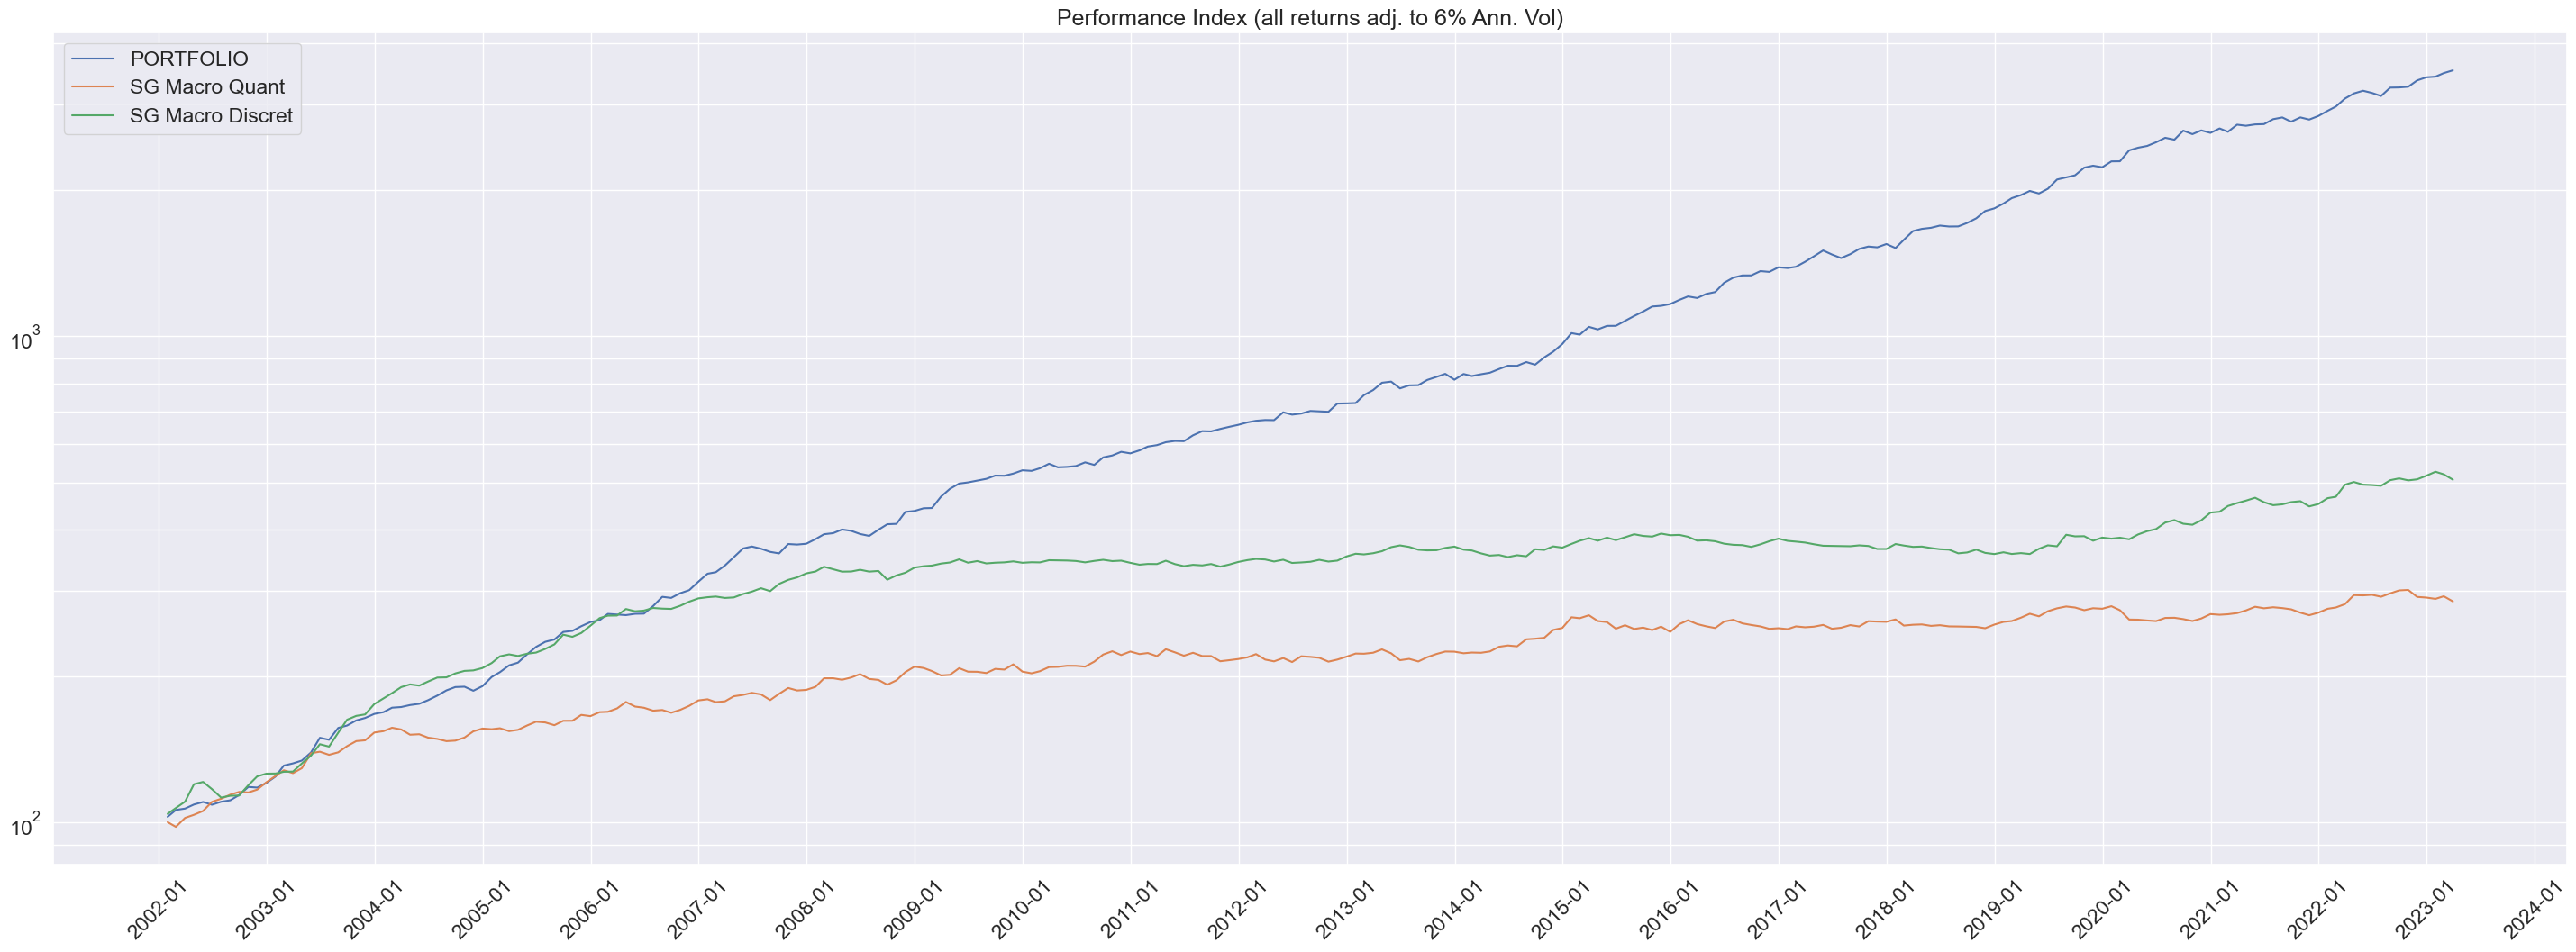

             1         2         3         4         5         6         7  \
Year                                                                         
2002  0.027496  0.033050  0.006585  0.019430  0.012084 -0.012963  0.014122   
2003  0.031192  0.053029  0.010479  0.013494  0.039072  0.072111 -0.009456   
2004  0.008408  0.021382  0.003082  0.009428  0.005876  0.017442  0.021759   
2005  0.044069  0.023194  0.032640  0.013023  0.040276  0.035416  0.024509   
2006  0.008803  0.030142 -0.003061 -0.002803  0.006328  0.000764  0.036446   
2007  0.038507  0.007438  0.032215  0.040525  0.041466  0.009510 -0.010499   
2008  0.022057  0.023473  0.005176  0.017444 -0.006332 -0.014880 -0.008954   
2009  0.012873  0.001073  0.055883  0.037302  0.025129  0.005524  0.008477   
2010 -0.002738  0.012421  0.021622 -0.016737  0.001958  0.004086  0.017589   
2011  0.014280  0.018221  0.006893  0.013948  0.005996 -0.001196  0.028153   
2012  0.011753  0.007623  0.003525 -0.000640  0.037845 -0.011045

In [118]:
# construct a plot of the total performance index of the portfolio and the benchmark
total_performance_index = (1.0 + returns_total_voladj).cumprod()*100.0

# plot the total performance index
plot_linechart(total_performance_index[['PORTFOLIO','SG Macro Quant', 'SG Macro Discret']], 'Performance Index (all returns adj. to 6% Ann. Vol)', 
               'Results Performance Index.png', False, True)

# create a table from the excess returns, such that the months are on the columns and the years are on the rows
def get_mytable(portfolio_returns):
    returns_Y = Cumulate_g_Returns({'freq': 'A', 'extrapolate': True})(portfolio_returns)
    
    returns_M = portfolio_returns.copy()
    returns_M['Month'] = returns_M.index.month
    returns_M['Year'] = returns_M.index.year
    
    my_table = returns_M.set_index(['Year', 'Month'])
    my_table = my_table.unstack(level='Month')
    my_table.columns = my_table.columns.droplevel()
    
    returns_Y['Year'] = returns_Y.index.year
    returns_Y = returns_Y.set_index('Year')
    returns_Y.columns = ['YTD']
    
    my_table = my_table.join(returns_Y)

    return my_table

my_table = get_mytable(returns[['PORTFOLIO']])
print(my_table)

# save the total performance index and portfolio_returns table to an excel 
with pd.ExcelWriter('Results_Performance_Index.xlsx') as writer:
    total_performance_index.to_excel(writer, sheet_name='Performance Index')
    my_table.to_excel(writer, sheet_name='MYTable')



TypeError: 'Axes' object is not subscriptable

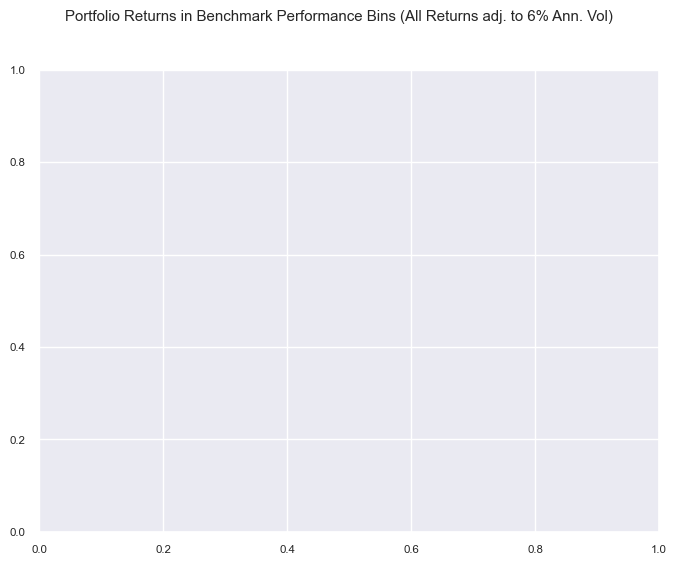

In [120]:
# Environment Analysis

df = returns_total_voladj.copy()

# Function to determine bins
def determine_bin(row, boundaries):
    for i, b in enumerate(boundaries):
        if row < b:
            return i
    return len(boundaries)

benchmark_label = {
                   'MSCI ACWI': 'MSCI ACWI',
                   'BTSYTRUH':'Long Dur Treasuries',
                   }

portfolios = ['PORTFOLIO', 'SG Macro Quant', 'SG Macro Discret']
# portfolios = ['PORTFOLIO_NextClose', 'SG Macro Quant',]

# Mapping bins to labels for clarity in the graph
bin_labels = ['0-10%', '10-30%', '30-70%', '70-90%', '90-100%']


sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('dark')
sns.set(font_scale=0.75)

# Creating subplots
fig, axs = plt.subplots(1, len(benchmark_label), figsize=(8*len(benchmark_label), 6))
fig.suptitle('Portfolio Returns in Benchmark Performance Bins (All Returns adj. to 6% Ann. Vol)', wrap=True)
# Width of a bar
bar_width = 0.40/len(portfolios)

records = {}
# Iterate over the benchmarks
for i, benchmark in enumerate(benchmark_label):
    # Calculate percentiles of benchmark returns
    percentiles = np.percentile(df[benchmark], [10, 30, 70, 90])

    df['bin'] = df[benchmark].apply(lambda x: determine_bin(x, percentiles))
    df['bin_label'] = df['bin'].map(dict(enumerate(bin_labels)))
    
    avg_returns = df.groupby('bin_label').mean()
    
    records[benchmark] = avg_returns
        
    # Creating index for grouped bar chart
    r1 = np.arange(len(avg_returns))
    
    for p, port in enumerate(portfolios):
        rp = [x + (p-1)*bar_width for x in r1]
        axs[i].bar(rp, avg_returns[port] * 100, width=bar_width, label=port)
    
    rb = [x + p*bar_width for x in r1]
    axs[i].bar(rb, avg_returns[benchmark] * 100, width=bar_width, label=benchmark_label[benchmark], alpha=0.7)
    
    #  Plotting for the current benchmark
    axs[i].set_title(f'{benchmark}')
    # axs[i].set_xlabel('Benchmark Return Percentile')
    axs[i].set_ylabel('Average Return (%)')
    axs[i].set_xticks([r + bar_width / 2 for r in range(len(avg_returns))])
    axs[i].set_xticklabels(avg_returns.index)
    axs[i].legend()
    axs[i].grid(True, axis='y', which='both')
    
    
# save
plt.savefig('Results Environment Analysis.png', bbox_inches='tight')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# save the dfexcel 
with pd.ExcelWriter('Results Environments Analysis.xlsx') as writer:
    for benchmark in records:
        records[benchmark].to_excel(writer, sheet_name=benchmark)


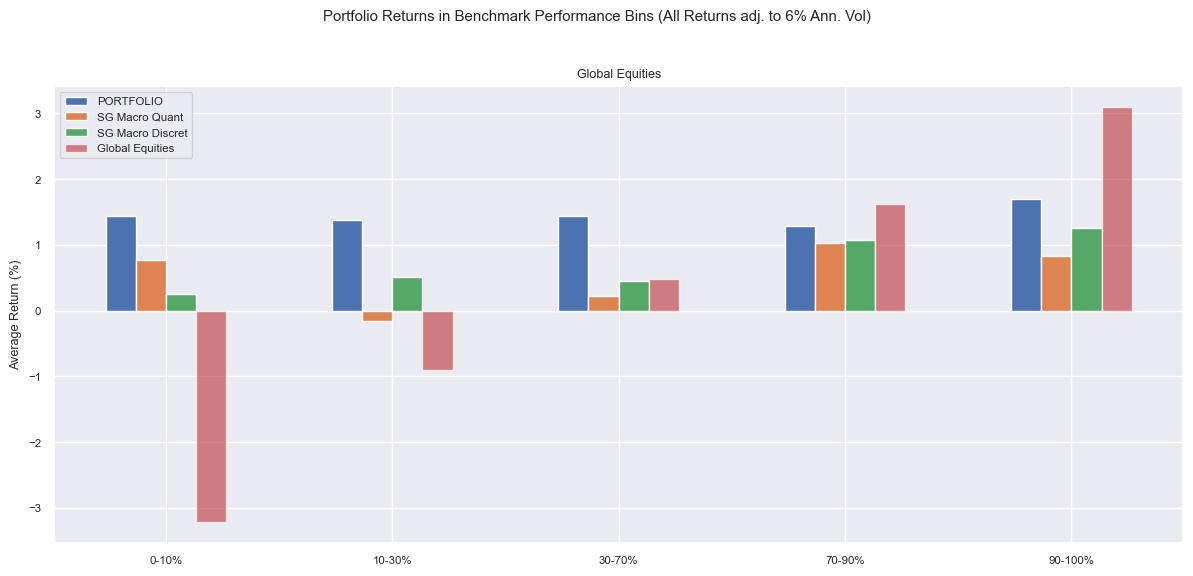

In [125]:
# Environment Analysis

df = returns_total_voladj.copy()

# Function to determine bins
def determine_bin(row, boundaries):
    for i, b in enumerate(boundaries):
        if row < b:
            return i
    return len(boundaries)

benchmark_label = {
                   'MSCI ACWI': 'Global Equities',
                   }

portfolios = ['PORTFOLIO', 'SG Macro Quant', 'SG Macro Discret']
# portfolios = ['PORTFOLIO_NextClose', 'SG Macro Quant',]

# Mapping bins to labels for clarity in the graph
bin_labels = ['0-10%', '10-30%', '30-70%', '70-90%', '90-100%']


sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('dark')
sns.set(font_scale=0.75)

# Creating subplots
fig, axs = plt.subplots(1, len(benchmark_label), figsize=(12*len(benchmark_label), 6))
fig.suptitle('Portfolio Returns in Benchmark Performance Bins (All Returns adj. to 6% Ann. Vol)', wrap=True)
# Width of a bar
bar_width = 0.40/len(portfolios)

records = {}
# Iterate over the benchmarks
for i, benchmark in enumerate(benchmark_label):
    # Calculate percentiles of benchmark returns
    percentiles = np.percentile(df[benchmark], [10, 30, 70, 90])

    df['bin'] = df[benchmark].apply(lambda x: determine_bin(x, percentiles))
    df['bin_label'] = df['bin'].map(dict(enumerate(bin_labels)))
    
    avg_returns = df.groupby('bin_label').mean()
    
    records[benchmark] = avg_returns
        
    # Creating index for grouped bar chart
    r1 = np.arange(len(avg_returns))
    
    for p, port in enumerate(portfolios):
        rp = [x + (p-1)*bar_width for x in r1]
        axs.bar(rp, avg_returns[port] * 100, width=bar_width, label=port)
    
    rb = [x + p*bar_width for x in r1]
    axs.bar(rb, avg_returns[benchmark] * 100, width=bar_width, label=benchmark_label[benchmark], alpha=0.7)
    
    #  Plotting for the current benchmark
    axs.set_title(f'{benchmark_label[benchmark]}')
    # axs.set_xlabel('Benchmark Return Percentile')
    axs.set_ylabel('Average Return (%)')
    axs.set_xticks([r + bar_width / 2 for r in range(len(avg_returns))])
    axs.set_xticklabels(avg_returns.index)
    axs.legend()
    axs.grid(True, axis='y', which='both')
    
    
# save
plt.savefig('Results Environment Analysis.png', bbox_inches='tight')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# save the dfexcel 
with pd.ExcelWriter('Results Environments Analysis.xlsx') as writer:
    for benchmark in records:
        records[benchmark].to_excel(writer, sheet_name=benchmark)
